In [3]:
# =============================================================================
# # impotrs
# =============================================================================
from utils.myexptorch import *
from utils.mycapsnet import *
from utils.capsnetutils import *
from utils.myfunction import *
import os
import cv2
import re
import yaml
import torch
import warnings
import numpy as np
import torchvision
from time import *
import pandas as pd
import torch.nn as nn
from PIL import Image
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import Counter
from collections import OrderedDict
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from scipy import stats
import argparse
import scanpy as sc
import gc 
from multiprocessing import cpu_count
n_jobs = cpu_count()
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
plt.rcParams['savefig.dpi'] = 100 #图片像素
plt.rcParams['figure.figsize'] = (16,12)


# =============================================================================
# # my imports & settings
# =============================================================================

n_class = 2


# =============================================================================
# # get configs
# =============================================================================
config_path = "configs/CaSee_Model_configs.yaml"
config_dict = yaml.safe_load(open(config_path, 'r'))
names = globals()
print('# ============================================================================= #','\n')
print("starting program...\n")
print("setting configs...\n")
begin_time = time()
# =============================================================================
# # setting configs
# =============================================================================
# data_arguments
work_dir = config_dict['data_arguments']['work_dir']
Counts_expr = config_dict['data_arguments']['Counts_expr']
Tissue_type = config_dict['data_arguments']['Tissue_type']
use_others = config_dict['data_arguments']['use_others']
remove_genes = config_dict['data_arguments']['remove_genes']

# cell cluster
cell_annotion = config_dict['cell_annotion']

# Marker_genes
if cell_annotion:
    T_cell_marker = config_dict['Marker_genes']['T_cell']
    Fibroblast_cell_marker = config_dict['Marker_genes']['Fibroblast']
    Myeloid_cell_marker = config_dict['Marker_genes']['Myeloid']
    B_cell_marker = config_dict['Marker_genes']['B_cell']
    Endothelial_cell_marker = config_dict['Marker_genes']['Endothelial']
    Mast_cell_marker = config_dict['Marker_genes']['Mast']
    DC_cell_marker = config_dict['Marker_genes']['DC']
    Candidate_Cancer_cell_marker = config_dict['Marker_genes']['Cancer']

# save_files
files = config_dict['save_files']['files']

# ckpt
ckpt = config_dict['ckpt']

# trainig_loop
my_times = config_dict['trainig_loop']['times']
batch_size = config_dict['trainig_loop']['batch_size']
max_epochs = config_dict['trainig_loop']['max_epochs']
seed = config_dict['trainig_loop']['seed']
lr = config_dict['trainig_loop']['lr']
split_data_seed = config_dict['trainig_loop']['split_data_seed']
gup = config_dict['trainig_loop']['gpu']
if ckpt:
    my_times = 0
if my_times>1:
    seed = None
print("setting complited...\n")

# ============================================================================= # 

starting program...

setting configs...

setting complited...



# ============================================================================= # 

prepare single-cell count matrix...

/home/yuansh/Desktop/GSE148673/GSM4476485_DCIS1_h5_file/GSM4476485_DCIS1_Candidate_cancer_expr.h5   does not exit, starting zip h5file...

Step.00 h5 file exits, loading h5 file...

Step.01 create scanpy obj and do tsne ... 

Step.02 remove genes ... 

total number of MT: 13
total number of RT: 99
total number of ERCC: 0
total number of non-coding RNA: 1929
total number of LNC_RNA: 940 

remove gene option:  False 

Step.03 running Stander workflow...

Step.04 running cell annotion...

B_cell_cluster_id : []
Candidate_Cancer_cell_cluster_id : ['0', '1', '2', '3', '4', '6', '8', '9', '12', '13', '14']
DC_cell_cluster_id : ['1', '3', '5', '11']
Endothelial_cell_cluster_id : ['1', '7', '8', '10']
Fibroblast_cell_cluster_id : ['1', '8', '9', '10', '15']
Mast_cell_cluster_id : []
Myeloid_cell_cluster_id : ['3', '5', '10', '11']
T_cell_cluster_id : ['14']
rest : []


... storing 'cell_type' as categorical


num candidate cancer cell:  1183 


 # ============================================================================= # 

starting BscModel...



757

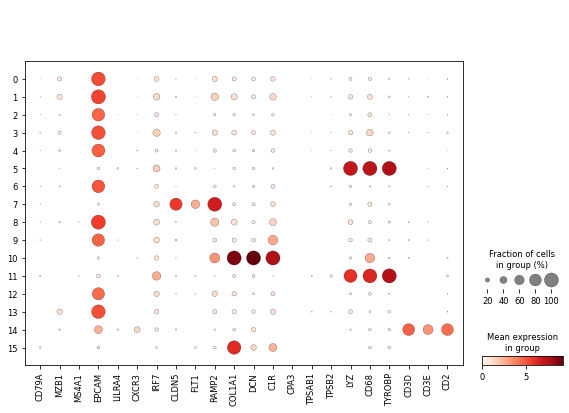

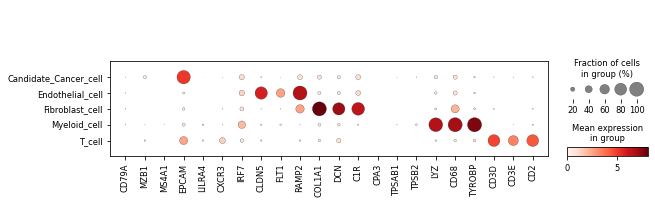

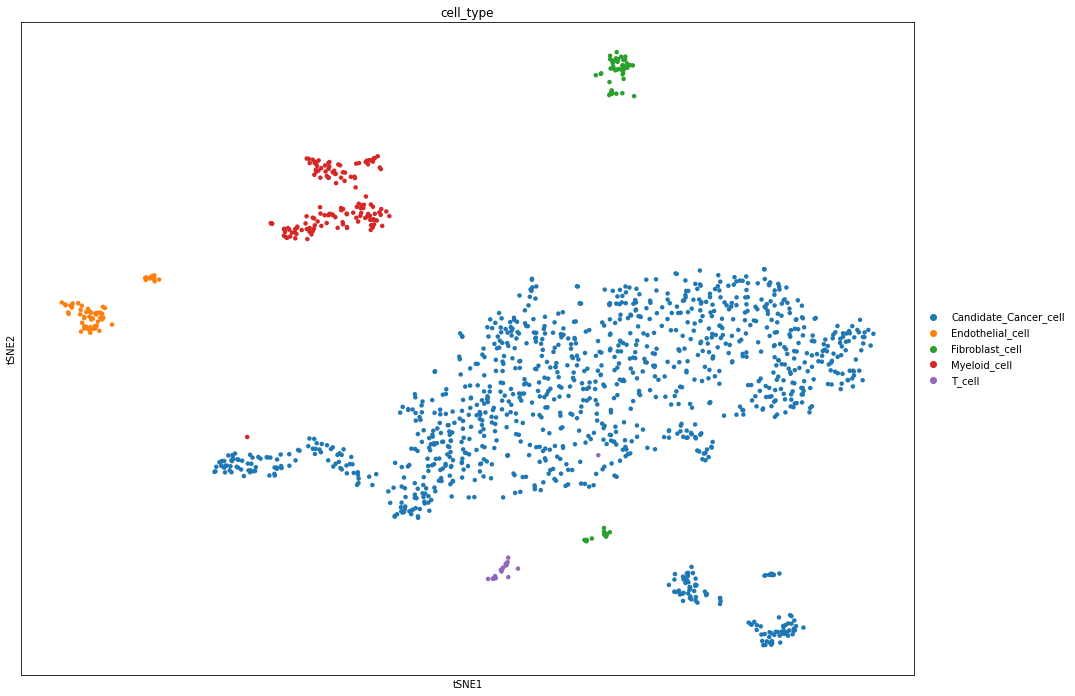

In [4]:
# =============================================================================
# create scRNA epxr
# =============================================================================
print('# ============================================================================= #','\n')
print("prepare single-cell count matrix...\n")

if not os.path.exists(work_dir+files+'_h5_file/'+files+'_Candidate_cancer_expr.h5'):
    print(work_dir+files+'_h5_file/'+files+'_Candidate_cancer_expr.h5   does not exit, starting zip h5file...\n')
    # =============================================================================
    # # create scanpy object
    # =============================================================================
    
    if not os.path.exists(work_dir + files+'_h5_file'):
        os.mkdir(work_dir + files+'_h5_file')
    if not os.path.exists(work_dir + files+'_h5_file/'+files+'_count_expr.h5'):
        begin_time = time()
        print("Step.00 h5 file not exits, loading count matrix and zip to h5 file...\n")
        if Counts_expr.endswith('.txt'):
            expr = pd.read_table(work_dir + Counts_expr, index_col=0).T
        elif Counts_expr.endswith('.csv'):
            expr = pd.read_csv(work_dir + Counts_expr, index_col=0).T
        else: print('count matrix must be csv or txt format')
        
        h5 = pd.HDFStore(work_dir + files+'_h5_file/'+files+'_count_expr.h5', 'w',
                         complevel=4, complib='blosc')
        h5['expr'] = expr
        h5.close()
        end_time = time()
        run_time = end_time-begin_time
        #print ('creating h5 file and loading time：',run_time,' seconds')
    else: 
        print("Step.00 h5 file exits, loading h5 file...\n")
        begin_time = time()
        expr = pd.read_hdf(work_dir + files+'_h5_file/'+files+'_count_expr.h5',key='expr')
        end_time = time()
        run_time = end_time-begin_time
        #print ('loading time：',run_time,' seconds')
        
    print("Step.01 create scanpy obj and do tsne ... \n")
    begin_time = time()
    # 0.loading caount matrix
    if cell_annotion:
        marker_genes = [i for i in names if '_cell_marker' in i]
        marker_genes.sort()
        cell_types = [re.sub("_marker","",i) for i in names if '_cell_marker' in i]
        cell_types.sort()
        gene_list = [j for i in marker_genes for j in names[i]]
        
    # 1.create scanpy object
    cellinfo = pd.DataFrame(expr.index, index=expr.index, columns=['sample_index'])
    geneinfo = pd.DataFrame(expr.columns,
                            index=expr.columns,
                            columns=['genes_index'])
    sce = sc.AnnData(expr, obs=cellinfo, var=geneinfo)
    sce.var_names_make_unique()
    sce.obs_names_make_unique()
    
    # 2.clean data calculate some gene information
    mt = sce.var_names[sce.var_names.str.match(r'^MT-')]  # 线粒体DNA
    rp = sce.var_names[sce.var_names.str.match(r'^RP[SL][0-9]')]  # 核糖体DNA
    ercc = sce.var_names[sce.var_names.str.match(r'^ERCC-')]  # 外源DNA
    ncRNA = sce.var_names[sce.var_names.str.match(
        r'^[A-Z][A-Z][0-9]*\.[0-9]')]  # 匹配有小数点的基因
    LOC = sce.var_names[sce.var_names.str.match(
        r'(^LOC|LINC)[1-9]*')]  # 匹配未知的LC rna
    
    # 3.statistics
    print("Step.02 remove genes ... \n")
    print("total number of MT: {}".format(len(mt)))
    print("total number of RT: {}".format(len(rp)))
    print("total number of ERCC: {}".format(len(ercc)))
    print("total number of non-coding RNA: {}".format(len(ncRNA)))
    print("total number of LNC_RNA: {}".format(len(LOC)),'\n')
    
    # 4.remove genes 
    print('remove gene option: ',remove_genes,'\n')
    if remove_genes:
        ids = list(rp) + list(ercc) + list(ncRNA) + list(LOC) + list(mt)
        print("Total Remove Genes {}".format(len(ids)))
        use_genes = sce.var.index.values
        ids = set(use_genes) - set(ids)
        print("Number of use Genes {}".format(len(ids)),'\n')
        sce = sce[:,sce.var.genes_index.isin(ids)]

    # 5.Stander workflow
    print('Step.03 running Stander workflow...\n')
    if not os.path.exists(work_dir + 'figures/'):
        os.mkdir(work_dir + 'figures/')
    sc.pp.normalize_total(sce, target_sum=1e6)
    sc.pp.log1p(sce)
    # 6. get marker gene list expr information
    if cell_annotion:
        sce.raw = sce
        sc.pp.highly_variable_genes(sce, n_top_genes=2000)
        sc.pp.scale(sce)
        sc.tl.pca(sce, svd_solver='arpack', use_highly_variable=True, random_state=seed)
        sc.pp.neighbors(sce, random_state=seed)
        sc.tl.leiden(sce, random_state=seed)
        sc.tl.tsne(sce, n_pcs=20,n_jobs=n_jobs)
    
        ids = sc.pl.dotplot(sce,
                            gene_list,
                            groupby='leiden',
                            return_fig=True)
        ids.savefig(filename=work_dir + 'figures/' + files + '_GeneMarkers_DotPlot.pdf',show=False)
        marker_expr = ids.dot_color_df
        marker_percent = ids.dot_size_df
    
    end_time = time()
    run_time = end_time-begin_time
    #print ('tsne finished using：',run_time,' seconds')
    
    # =============================================================================
    # cell_annotion
    # =============================================================================
    # first annotion
    if cell_annotion:
        print("Step.04 running cell annotion...\n")
        rest_cluster_id = []
        for cell_type,marker_gene in zip(cell_types,marker_genes):
            ids = cell_type + '_cluster_id'
            names[ids] = (marker_percent[names[marker_gene]] > 0.333) & marker_expr[names[marker_gene]] > 0
            names[ids] = list(names[ids][names[ids].sum(axis=1) > 0].index)
            print(ids, ':', names[ids])
            rest_cluster_id += names[ids]
            names[cell_type] = sce.obs.leiden[sce.obs.leiden.isin(names[ids])].index
        rest_cluster_id = list(set(sce.obs.leiden) - set(rest_cluster_id))
        print('rest', ':', rest_cluster_id)
        rest = sce.obs.leiden[sce.obs.leiden.isin(rest_cluster_id)].index
        
        begin_time = time()
        check_unique = []
        num_cell_types = len(cell_types)
        if not os.path.exists(work_dir + 'figures/dotplot_figures/'):
            os.mkdir(work_dir + 'figures/dotplot_figures/')
            
        for i in range(num_cell_types-1):
            for j in range(i+1, num_cell_types):
                cluster_id = set(names[cell_types[i] + '_cluster_id']
                                 ).intersection(names[cell_types[j] + '_cluster_id'])
                if len(cluster_id) != 0:
                    check_unique.append([cell_types[i],cell_types[j],cluster_id])
        
        # annotion again, adjust and remove duplicated
        unique_cells = []
        for check_list in check_unique:
            cluster_list = check_list[2]
            num_cluster = len(check_list[2])
            cells = []
            for i in range(num_cluster):
                title = check_list[0] + ' vs ' + check_list[1]
                ids = sc.pl.dotplot(sce[sce.obs.leiden == list(cluster_list)[i], ],
                                    gene_list, groupby='leiden',
                                    title=title, return_fig=True)
                cluster_expr = ids.dot_color_df.stack().idxmax()
                cluster_precent = ids.dot_size_df.stack().idxmax()
                cells += [marker_gene[:-7] for marker_gene in marker_genes if cluster_expr[1] in names[marker_gene]]
                # ids.savefig(filename='figures/dotplot_figures/'+title +
                #             "_cluster " + str(list(cluster_list)[i]), show=False)
            unique_cells.append(cells)
            
            
        rest_annotion = []
        for ids in rest_cluster_id:

            ids = sc.pl.dotplot(sce[sce.obs.leiden == ids, ],
                                gene_list,
                                groupby='leiden',
                                return_fig=True)
            cluster_expr = ids.dot_color_df.stack().idxmax()
            cluster_precent = ids.dot_size_df.stack().idxmax()
            if (ids.dot_color_df.max().max() < -0.5) | (ids.dot_size_df.max().max() < 0.05):
                rest_annotion += ['Z_Candidate']
            else:
                rest_annotion += [
                    marker_gene[:-7] for marker_gene in marker_genes
                    if cluster_expr[1] in names[marker_gene]
                ]
                
        sce.obs['cell_type'] = 'Z_Candidate'
        for cell_type in cell_types:
            sce.obs.loc[names[cell_type],'cell_type'] = cell_type
        
        for cluster_id, cell_type in zip(check_unique,unique_cells):
            num = len(cell_type)
            for ids in range(num):
                cell_annotion = cell_type[ids]
                cell_cluster = list(cluster_id[2])[ids]
                sce.obs.loc[sce.obs.leiden == cell_cluster,'cell_type'] = cell_annotion
                
        for cluster_id, cell_type in zip(rest_cluster_id,rest_annotion):
            sce.obs.loc[sce.obs.leiden == cluster_id,'cell_type'] = cell_type
            
        end_time = time()
        run_time = end_time-begin_time
        # print ('cell annotion finished using：',run_time,' seconds')
        
        # plot and save files 
        ids = sc.pl.dotplot(sce,
                      gene_list,
                      groupby='cell_type',return_fig=True,show=False)
        ids.savefig(filename=work_dir + 'figures/' + files + '_CellType_GeneMarkers_DotPlot.pdf',show=False)
        ids = sc.pl.tsne(sce, color='cell_type',return_fig=True,show=False)
        ids.savefig(fname=work_dir + 'figures/' + files + '_CellType_Tsne.pdf',show=False)
       
        sce.obs.to_csv(work_dir + files+'_h5_file/'+files+'_cell_annotion.csv')
        
        if use_others:
            use_cells = sce.obs[sce.obs['cell_type'].isin(['Candidate_Cancer_cell','Z_Candidate'])].index
        else:
            use_cells = sce.obs[sce.obs['cell_type'].isin(['Candidate_Cancer_cell'])].index
        print('num candidate cancer cell: ',len(use_cells),'\n')    
        sce = sce.raw.to_adata()
        h5 = pd.HDFStore(work_dir + files+'_h5_file/'+files+'_Candidate_cancer_expr.h5', 'w',
                         complevel=4, complib='blosc')
        h5['expr'] = sce[use_cells].to_df()
        h5.close()
    else:
        h5 = pd.HDFStore(work_dir + files+'_h5_file/'+files+'_Candidate_cancer_expr.h5', 'w',
                         complevel=4, complib='blosc')
        h5['expr'] = sce.to_df()
        h5.close()
    print('\n','# ============================================================================= #','\n')
    print('starting BscModel...\n')
    del sce, cellinfo, geneinfo
    gc.collect()
else:
    print(work_dir+files+'_h5_file/'+files+'_Candidate_cancer_expr.h5 exit starting BscModel...\n')    
# =============================================================================


In [6]:
print("Starting trainig BscModel...")
from pathlib import Path
UseTypeList = [
    'LUSC', 'LUAD', 'LIHC', 'KIRP', 'COAD',
    'PRAD', 'STAD', 'HNSC', 'SKCM',
    'THCA', 'READ', 'PAAD', 'ACC', 'GBM',
    'LGG', 'KIRC', 'BRCA', 'ESCA',
    'Blood', 'Blood Vessel', 'Brain', 'Skin',
    'Thyroid', 'Pancreas', 'Muscle', 'Lung', 'Colon',
    'Nerve',  'Breast', 'Esophagus', 'Small Intestine', 'Spleen',
    'Adrenal Gland', 'Stomach', 'Liver', 'Prostate']
# =============================================================================
# get deafult matrix
# =============================================================================
IdList = [i for i in range(len(UseTypeList))]
RefTable = pd.DataFrame({'TypeList': UseTypeList, 'IdList': IdList})
n_class = 2
scale_method = 'std'
assert max_epochs >= 20, 'max_epochs must be more than 20'

# =============================================================================
# Dataloader Attention:
#       1. the data only need log-tranformed
#       2. do not filter anything, the model will auto-filter
# =============================================================================

print("Step.1 Data Loading && save h5 file")
if not os.path.exists(work_dir + files+'_h5_file/'+files+'_Bulk.h5'):
    expr = pd.read_hdf('ref_data/tcga-gtex.h5', key='expr').T
    meta = pd.read_hdf('ref_data/tcga-gtex.h5', key='meta')
    Candidate_cancer_expr = pd.read_hdf(work_dir + 
        files+'_h5_file/'+files+'_Candidate_cancer_expr.h5', key='expr')
    # # Step1.1.2 intersect scExpr and bulkExpr
    ids = expr.columns.intersection(set(Candidate_cancer_expr.columns))
    expr = expr[ids]
    Candidate_cancer_expr = Candidate_cancer_expr[ids]
    # # save h5
    h5 = pd.HDFStore(work_dir + files+'_h5_file/'+files+'_Bulk.h5', 'w',
                     complevel=4, complib='blosc')
    h5['expr'] = expr
    h5['meta'] = meta
    h5['Candidate_cancer_expr'] = Candidate_cancer_expr
    h5.close()
print("h5 file prepare completed!\n")


if my_times > 0:
    print('ckpt does not exit, traing model...')
    print("loading h5 file...\n")
    expr = pd.read_hdf(work_dir + files+'_h5_file/' +
                       files+'_Bulk.h5', key='expr')
    meta = pd.read_hdf(work_dir + files+'_h5_file/' +
                       files+'_Bulk.h5', key='meta')

    # Step.1.1 set classifer group
    print("papering BscModel...")
    tcga = [i for i in meta.index if 'TCGA' in i]
    gtex = [i for i in meta.index if 'GTEX' in i]
    tcgaNormal = np.where([int(i.split('-')[3]) > 9 for i in tcga])[0]
    tcgaNormal = [tcga[i] for i in tcgaNormal]
    meta.loc[tcga, 'label'] = 1
    meta.loc[gtex, 'label'] = 0
    meta.loc[tcgaNormal, 'label'] = 0

    assert all(
        expr.index == meta.index), 'bulk_expr samples does not  mapping bulk_info samples, plz  check data integrity'
    meta = meta.loc[meta['Tissue'].isin(UseTypeList), :]
    expr = expr.loc[meta.index, :]
    print("Loadiing completed !!! ")

    print("Step.2 Trainig loop")
    # Step.1.2 save genes
    genes = expr.columns
    print('Using number of genes: ', len(genes))
    # Step.2 Data Scale
    expr_normal = DataFrame_normalize(expr, scale_method)
    
    del expr, tcga, gtex
    gc.collect()
    
    for my_time in range(my_times):
        print('running time:', my_time+1)
        # Step.3 Data to Tensor
        XRawData = expToTorch(expr_normal)
        YRawData = labelTotorch(meta['label'])
        TissueLabel_count = Counter(meta['label'])
        randoms = split_data_seed

        # Step.4 data split to train - test
        stratify = YRawData.cpu().numpy().copy()
        x_train, x_test, y_train, y_test = train_test_split(
            XRawData, YRawData, stratify=stratify,
            test_size=0.1, random_state=randoms)

        # Step.4.1 label to one-hot ( call "toLabel" to undo)
        stratify = y_train.cpu().numpy().copy()
        y_train = toOneHot(y_train, n_class).int()
        y_test = toOneHot(y_test, n_class).int()

        # Step.5 train data split validation data
        x_train, x_val, y_train, y_val = train_test_split(
            x_train, y_train, stratify=stratify,
            test_size=0.1, random_state=randoms)

        # Step.6 transform to iterate object
        train_iter = makeDataiter(x_train, y_train, batch_size=batch_size)
        val_iter = makeDataiter(x_val, y_val, batch_size=batch_size)
        test_iter = makeDataiter(x_test, y_test, batch_size=batch_size)

        print("Bulk Data preparation is complete.")
        print("Starting training loop...")
        # set seed
        if seed:
            pl.utilities.seed.seed_everything(seed=seed)

        myloss = CapsLoss()
        model = CapsuleNet(n_class=2, n_genes=len(genes), loss_func=myloss,
                           out_feature=28, need_to_matrix=True,
                           cov_in=1, cov_out=256, cov_kernel_size=9,
                           pc_input_channels=256, pc_output_caps=32, pc_output_dim=8, pc_kernel_size=9, pc_stride=2,
                           rc_in_dim=8, rc_in_caps=32 * 6 * 6, rc_dim_caps=16, rc_num_routing=3, lr=lr)
        # output file
        OUTPUT_DIR = work_dir + 'lightning_logs'
        tb_logger = pl.loggers.TensorBoardLogger(save_dir=work_dir,
                                                 name=work_dir + files)

        # set check point to choose best model
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=tb_logger.log_dir,
            filename='{epoch}-{val_acc:.4f}',
            save_top_k=5,  # keep top 5
            monitor='val_acc',  # check acc
            mode='max'
        )

        # train loop
        trainer = pl.Trainer(gpus=-1,
                             callbacks=[checkpoint_callback],
                             max_epochs=max_epochs,
                             gradient_clip_val=0,
                             auto_lr_find=False)  # 开始训练
        trainer.fit(model, train_iter, val_iter)

        # =============================================================================
        # Get best model
        # =============================================================================
        out = Path(tb_logger.log_dir)
        print(out)
        ckpt_list = [ckpt.stem + '.ckpt' for ckpt in out.iterdir()]
        max_acc = [float(i.split('-')[1].split('val_acc=')[1].split('.ckpt')[0])
                   for i in ckpt_list]
        assert max(max_acc) > 0.95, 'Fail the test'
        max_acc = [i/max(max_acc) == 1 for i in max_acc]
        ckpt_list = np.array(ckpt_list)[np.array(max_acc)]
        ckpt = ckpt_list[np.argmax(
            [float(i.split('-')[0].split('epoch=')[1]) for i in ckpt_list])]
        print('useing ckpt:', ckpt)
        # check bulk result
        if seed:
            pl.utilities.seed.seed_everything(seed=seed)
        pl_accuracy = torchmetrics.Accuracy()
        pl_recall = torchmetrics.Recall(average='none', num_classes=2)
        myloss = CapsLoss()
        # loading
        ckpt_path = str(out) + '/' + ckpt
        if seed:
            pl.utilities.seed.seed_everything(seed=seed)
        model = CapsuleNet(n_class=2, n_genes=len(genes), loss_func=myloss,
                           out_feature=28, need_to_matrix=True,
                           cov_in=1, cov_out=256, cov_kernel_size=9,
                           pc_input_channels=256, pc_output_caps=32, pc_output_dim=8, pc_kernel_size=9, pc_stride=2,
                           rc_in_dim=8, rc_in_caps=32 * 6 * 6, rc_dim_caps=16, rc_num_routing=3)
        model = model.load_from_checkpoint(ckpt_path,
                                           n_class=2, n_genes=len(genes), loss_func=myloss,
                                           out_feature=28, need_to_matrix=True,
                                           cov_in=1, cov_out=256, cov_kernel_size=9,
                                           pc_input_channels=256, pc_output_caps=32, pc_output_dim=8, pc_kernel_size=9, pc_stride=2,
                                           rc_in_dim=8, rc_in_caps=32 * 6 * 6, rc_dim_caps=16, rc_num_routing=3)
        if gpus == True:
            trainer = pl.Trainer(gpus=-1)
        else:
            trainer = pl.Trainer()
        trainer.test(model, test_iter)

        # predict
        # th = predict_th
        y = torch.cat(model.test_sample_label)
        predict = torch.cat(model.test_predict)
        pl_accuracy = torchmetrics.Accuracy()
        acc = pl_accuracy(toLabel(predict), toLabel(y))
        print("Bulk acc：", acc)
        # loading scexpr
        Candidate_cancer_expr = pd.read_hdf(work_dir +
                                            files+'_h5_file/'+files+'_Bulk.h5', key='Candidate_cancer_expr')

        # =============================================================================
        # predict sc-data
        # =============================================================================
        model.test_predict = []
        model.test_sample_label = []
        model.test_decoder = []
        model.test_matrix = []
        model.test_conv = []
        model.test_primary = []
        model.test_digitcaps = []

        assert Tissue_type in ['Tumor', 'Adjacent',
                               'Normal', 'Unknow'], 'tissue type error!'
        if Tissue_type == 'Tumor':
            label = np.array(
                [1 for i in range(Candidate_cancer_expr.shape[0])])
        else:
            label = np.array(
                [0 for i in range(Candidate_cancer_expr.shape[0])])

        XRawData = expToTorch(Candidate_cancer_expr)
        YRawData = labelTotorch(label)
        # predict
        scepi_iter = makeDataiter(
            XRawData, YRawData, batch_size=batch_size, shuffle=False)
        trainer.test(model, scepi_iter)
        # predict
        y = torch.cat(model.test_sample_label)
        predict = torch.cat(model.test_predict)
        pl_accuracy = torchmetrics.Accuracy()
        acc = pl_accuracy(toLabel(predict), y)

        predict = pd.DataFrame(torch.cat(model.test_predict).numpy())
        predict.columns = ['Normal_like', 'Tumor_like']
        
        predict.index = Candidate_cancer_expr.index
        ids = predict['Normal_like'] + predict['Tumor_like']
        predict['scale_Normal_probe'] = predict['Normal_like']/ids
        predict['scale_Tumor_probe'] = predict['Tumor_like']/ids
        
    
        if Tissue_type == 'Tumor':
            ids = min(predict['Tumor_like'].mean(),predict['Tumor_like'].median())
            weight = np.sin(ids*np.pi/2)
            ids = (1-weight) * predict['Normal_like'] + weight * predict['Tumor_like']
            predict['weight_Normal_probe'] =  (1-weight) * predict['Normal_like']/ids
            predict['weight_Tumor_probe'] =   weight * predict['Tumor_like']/ids
            predict['weight_predict'] = 'Normal'
            ids = predict['weight_Tumor_probe']>(predict['weight_Normal_probe']+0.5)
            predict.loc[ids,'weight_predict'] = 'Cancer'
        else:
            ids = min(predict['Normal_like'].mean(),predict['Normal_like'].median())
            weight = np.sin(ids*np.pi/2)
            ids = (1-weight) * predict['Tumor_like'] + weight * predict['Normal_like']
            predict['weight_Normal_probe'] =  weight * predict['Normal_like']/ids
            predict['weight_Tumor_probe'] =   (1-weight) * predict['Tumor_like']/ids
            predict['weight_predict'] = 'Cancer'
            ids = predict['weight_Normal_probe']>(predict['weight_Tumor_probe']+0.5)
            predict.loc[ids,'weight_predict'] = 'Normal'


        if Tissue_type == 'Tumor':
            predict['Moderate'] = predict['weight_predict'] 
            ids = (predict['Tumor_like'] - predict['Normal_like'] <= 0.1) & (predict['Tumor_like'] > predict['Normal_like'])
            predict.loc[ids,'Moderate'] = 'Moderate'

        if Tissue_type != 'Tumor':
            predict['Moderate'] = predict['weight_predict'] 
            ids = (predict['Normal_like'] - predict['Tumor_like'] <= 0.1) & (predict['Tumor_like'] < predict['Normal_like'])
            predict.loc[ids,'Moderate'] = 'Moderate'
        
        predict['scale_predict'] = 'Normal'
        ids = predict['scale_Normal_probe'] < predict['scale_Tumor_probe']
        predict.loc[ids,'scale_predict'] = 'Cancer'    
        predict.to_csv(work_dir + files+'_h5_file/'+files+'_predict_'+ 'times_' + str(my_time+1)+'.csv')
        
        del model
        gc.collect()
    print("Step.3 Integration of the data...")
    
    
    predict_files = [files+'_predict_'+ 'times_' + str(i+1)+'.csv' for i in range(my_times)]
    for predict_file in predict_files:
        names[predict_file] = pd.read_csv(work_dir + files+'_h5_file/'+predict_file,index_col=0)
        
    integrated = names[predict_files[0]].iloc[:,0:6]
    for i in range(1,my_times):
        integrated += names[predict_files[i]].iloc[:,0:6]
    integrated = integrated/my_times
    
    predict = names[predict_files[0]].iloc[:,6:7]
    for i in range(1,my_times):
        predict = pd.concat([predict,names[predict_files[i]].iloc[:,6:7]],axis=1)
    ids = ['weight_predict_'+str(i+1) for i in range(my_times)]
    
    predict.columns = ids
    p_vals = predict.replace(['Cancer','Normal'],[1,0])
    times = list(p_vals.sum(axis=1))
    p_vals = [1 - stats.binom.pmf(np.arange(0,time+1,1),my_times,0.5).sum() for time in times]
    predict['weight_predict_Times'] = times
    predict['weight_predict_P_vals'] = p_vals
    predict['weight_predict_P_vals_adj'] = p_adjust_bh(predict['weight_predict_P_vals'])
    
    integrated = pd.concat([integrated,predict[['weight_predict_Times','weight_predict_P_vals','weight_predict_P_vals_adj']]],axis=1)
    integrated['weight_predict'] = 'Normal'
    ids = integrated['weight_predict_P_vals_adj']<0.05
    integrated.loc[ids,'weight_predict'] = 'Cancer'
    
    predict = names[predict_files[0]].iloc[:,8:9]
    for i in range(1,my_times):
        predict = pd.concat([predict,names[predict_files[i]].iloc[:,8:9]],axis=1)
    ids = ['scale_predict_'+str(i+1) for i in range(my_times)]
    predict.columns = ids
    p_vals = predict.replace(['Cancer','Normal'],[1,0])
    times = list(p_vals.sum(axis=1))
    p_vals = [1 - stats.binom.pmf(np.arange(0,time+1,1),my_times,0.5).sum() for time in times]
    predict['scale_predict_Times'] = times
    predict['scale_predict_P_vals'] = p_vals    
    predict['scale_predict_P_vals_adj'] = p_adjust_bh(predict['scale_predict_P_vals'])
    
    predict = pd.concat([integrated,predict[['scale_predict_Times','scale_predict_P_vals','scale_predict_P_vals_adj']]],axis=1)
    predict['scale_predict'] = 'Normal'
    ids = predict['scale_predict_P_vals_adj']<0.05
    predict.loc[ids,'scale_predict'] = 'Cancer'
    
    
    
    if Tissue_type == 'Tumor':
        predict['Moderate'] = predict['weight_predict'] 
        ids = (predict['Tumor_like'] - predict['Normal_like'] <= 0.1) & (predict['Tumor_like'] > predict['Normal_like'])
        predict.loc[ids,'Moderate'] = 'Moderate'
    
    if Tissue_type != 'Tumor':
        predict['Moderate'] = predict['weight_predict'] 
        ids = (predict['Normal_like'] - predict['Tumor_like'] <= 0.1) & (predict['Tumor_like'] < predict['Normal_like'])
        predict.loc[ids,'Moderate'] = 'Moderate'
    
    
    
    predict['scale_predict'] = 'Normal'
    ids = predict['scale_Normal_probe'] < predict['scale_Tumor_probe']
    predict.loc[ids,'scale_predict'] = 'Cancer'
    predict.to_csv(work_dir + files+'_h5_file/'+files+'_predict_Integration_'+'.csv')
    
else:
    print('ckpt exit, using path: ', ckpt)
    # loading scexpr
    Candidate_cancer_expr = pd.read_hdf(work_dir +
                                        files+'_h5_file/'+files+'_Bulk.h5', key='Candidate_cancer_expr')
    genes = Candidate_cancer_expr.columns
    if seed:
        pl.utilities.seed.seed_everything(seed=seed)
    pl_accuracy = torchmetrics.Accuracy()
    pl_recall = torchmetrics.Recall(average='none', num_classes=2)
    myloss = CapsLoss()
    # loading
    ckpt_path = ckpt
    if seed:
        pl.utilities.seed.seed_everything(seed=seed)
    model = CapsuleNet(n_class=2, n_genes=len(genes), loss_func=myloss,
                       out_feature=28, need_to_matrix=True,
                       cov_in=1, cov_out=256, cov_kernel_size=9,
                       pc_input_channels=256, pc_output_caps=32, pc_output_dim=8, pc_kernel_size=9, pc_stride=2,
                       rc_in_dim=8, rc_in_caps=32 * 6 * 6, rc_dim_caps=16, rc_num_routing=3)
    model = model.load_from_checkpoint(ckpt_path,
                                       n_class=2, n_genes=len(genes), loss_func=myloss,
                                       out_feature=28, need_to_matrix=True,
                                       cov_in=1, cov_out=256, cov_kernel_size=9,
                                       pc_input_channels=256, pc_output_caps=32, pc_output_dim=8, pc_kernel_size=9, pc_stride=2,
                                       rc_in_dim=8, rc_in_caps=32 * 6 * 6, rc_dim_caps=16, rc_num_routing=3)
    if gpu == True:
        trainer = pl.Trainer(gpus=-1)
    else:
        trainer = pl.Trainer()
    # =============================================================================
    # predict sc-data
    # =============================================================================
    model.test_predict = []
    model.test_sample_label = []
    model.test_decoder = []
    model.test_matrix = []
    model.test_conv = []
    model.test_primary = []
    model.test_digitcaps = []
    
    assert Tissue_type in ['Tumor','Adjacent','Normal','Unknow'], 'tissue type error!'
    if Tissue_type == 'Tumor':
        label = np.array([1 for i in range(Candidate_cancer_expr.shape[0])])
    else: label = np.array([0 for i in range(Candidate_cancer_expr.shape[0])])
        
    XRawData = expToTorch(Candidate_cancer_expr)
    YRawData = labelTotorch(label)
    # predict
    scepi_iter = makeDataiter(
        XRawData, YRawData, batch_size=batch_size, shuffle=False)
    trainer.test(model, scepi_iter)
    # predict
    y = torch.cat(model.test_sample_label)
    predict = torch.cat(model.test_predict)
    pl_accuracy = torchmetrics.Accuracy()
    acc = pl_accuracy(toLabel(predict), y)
    
    predict = pd.DataFrame(torch.cat(model.test_predict).numpy())
    predict.columns = ['Normal_like', 'Tumor_like']
    
    predict.index = Candidate_cancer_expr.index
    ids = predict['Normal_like'] + predict['Tumor_like']
    predict['scale_Normal_probe'] =  predict['Normal_like']/ids
    predict['scale_Tumor_probe'] =  predict['Tumor_like']/ids
    
    if Tissue_type == 'Tumor':
        ids = min(predict['Tumor_like'].mean(),predict['Tumor_like'].median())
        weight = np.sin(ids*np.pi/2)
        ids = (1-weight) * predict['Normal_like'] + weight * predict['Tumor_like']
        predict['weight_Normal_probe'] =  (1-weight) * predict['Normal_like']/ids
        predict['weight_Tumor_probe'] =   weight * predict['Tumor_like']/ids
        predict['weight_predict'] = 'Normal'
        ids = predict['weight_Tumor_probe']>(predict['weight_Normal_probe']+0.5)
        predict.loc[ids,'weight_predict'] = 'Cancer'
    else:
        ids = min(predict['Normal_like'].mean(),predict['Normal_like'].median())
        weight = np.sin(ids*np.pi/2)
        ids = (1-weight) * predict['Tumor_like'] + weight * predict['Normal_like']
        predict['weight_Normal_probe'] =  weight * predict['Normal_like']/ids
        predict['weight_Tumor_probe'] =   (1-weight) * predict['Tumor_like']/ids
        predict['weight_predict'] = 'Cancer'
        ids = predict['weight_Normal_probe']>(predict['weight_Tumor_probe']+0.5)
        predict.loc[ids,'weight_predict'] = 'Normal'
    
    if Tissue_type == 'Tumor':
        predict['Moderate'] = predict['weight_predict'] 
        ids = (predict['Tumor_like'] - predict['Normal_like'] <= 0.1) & (predict['Tumor_like'] > predict['Normal_like'])
        predict.loc[ids,'Moderate'] = 'Moderate'
    
    if Tissue_type != 'Tumor':
        predict['Moderate'] = predict['weight_predict'] 
        ids = (predict['Normal_like'] - predict['Tumor_like'] <= 0.1) & (predict['Tumor_like'] < predict['Normal_like'])
        predict.loc[ids,'Moderate'] = 'Moderate'
    
    predict['scale_predict'] = 'Normal'
    ids = predict['scale_Normal_probe'] < predict['scale_Tumor_probe']
    predict.loc[ids,'scale_predict'] = 'Cancer'
    predict.to_csv(work_dir + files+'_h5_file/'+files+'_ckpt_predict.csv')

Starting trainig BscModel...
Step.1 Data Loading && save h5 file
h5 file prepare completed!

ckpt does not exit, traing model...
loading h5 file...

papering BscModel...
Loadiing completed !!! 
Step.2 Trainig loop
Using number of genes:  8647


20955

running time: 1


Missing logger folder: /home/yuansh/Desktop/GSE148673/GSM4476485_DCIS1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bulk Data preparation is complete.
Starting training loop...



  | Name         | Type              | Params
---------------------------------------------------
0 | myloss       | CapsLoss          | 0     
1 | pl_accuracy  | Accuracy          | 0     
2 | to_matrix    | sampleToMatrix    | 6.8 M 
3 | conv         | Conv2d            | 21.0 K
4 | relu         | ReLU              | 0     
5 | primary_caps | PrimaryCaps       | 5.3 M 
6 | digit_caps   | DigitCaps         | 294 K 
7 | decoder      | ReconstructionNet | 9.4 M 
---------------------------------------------------
21.8 M    Trainable params
0         Non-trainable params
21.8 M    Total params
87.240    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

mean_val_loss:  99.16910552978516 	 mean_val_acc:  0.48828125


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

mean_val_loss:  0.7719503745436669 	 mean_val_acc:  0.99375


Validating: 0it [00:00, ?it/s]

mean_val_loss:  0.8146219670772552 	 mean_val_acc:  0.99375


Validating: 0it [00:00, ?it/s]

mean_val_loss:  0.643477027118206 	 mean_val_acc:  0.9924904346466065


Validating: 0it [00:00, ?it/s]

mean_val_loss:  0.6817560754716396 	 mean_val_acc:  0.9914700269699097


Validating: 0it [00:00, ?it/s]

mean_val_loss:  0.743839411251247 	 mean_val_acc:  0.9911670923233032


Validating: 0it [00:00, ?it/s]

mean_val_loss:  0.576128398347646 	 mean_val_acc:  0.99453125


Validating: 0it [00:00, ?it/s]

mean_val_loss:  0.483749314135639 	 mean_val_acc:  0.99609375


Validating: 0it [00:00, ?it/s]

mean_val_loss:  0.5040734242647886 	 mean_val_acc:  0.996875


Validating: 0it [00:00, ?it/s]

mean_val_loss:  0.5740349508821965 	 mean_val_acc:  0.9942920923233032


Validating: 0it [00:00, ?it/s]

mean_val_loss:  0.5337350141140632 	 mean_val_acc:  0.9958545923233032


Validating: 0it [00:00, ?it/s]

mean_val_loss:  0.5031491959103732 	 mean_val_acc:  0.99609375


Validating: 0it [00:00, ?it/s]

mean_val_loss:  0.5120659962063655 	 mean_val_acc:  0.99609375


Validating: 0it [00:00, ?it/s]

mean_val_loss:  0.5281743050480145 	 mean_val_acc:  0.99609375


Validating: 0it [00:00, ?it/s]

mean_val_loss:  0.5768506005581002 	 mean_val_acc:  0.9953125


Validating: 0it [00:00, ?it/s]

mean_val_loss:  0.5250803651171736 	 mean_val_acc:  0.99609375


Validating: 0it [00:00, ?it/s]

mean_val_loss:  0.5597111350856722 	 mean_val_acc:  0.9956154346466064


Validating: 0it [00:00, ?it/s]

mean_val_loss:  0.5276350801810622 	 mean_val_acc:  0.9958545923233032
/home/yuansh/Desktop/GSE148673/GSM4476485_DCIS1/version_0
useing ckpt: epoch=7-val_acc=0.9968.ckpt


KeyboardInterrupt: 